In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns

In [82]:
data = pd.read_csv("../01_create/" + "240103_lp_data_with_sc_and_rec_usage.csv")
data = data.sort_values(by=['pool_addr', 'liquidity_provider', 'week'])
price_info = pd.read_csv("../01_create/" + "240103_weekly_pool_agg_results.csv")
def qtile_25(x):
    return x.quantile(0.25)
def qtile_75(x):
    return x.quantile(0.75)
def qtile_10(x):
    return x.quantile(0.10)
def qtile_90(x):
    return x.quantile(0.90)

In [83]:
sc_conditions_list = [
    data['sc_usage_avg'] == 0,
    data['sc_usage_avg'] == 1,
]
sc_choice_list = [
    'no_sc',
    'full_sc',
]
data['sc_type'] = np.select(sc_conditions_list, sc_choice_list, default='mixed')

rec_conditions_list = [
    (data['rec_usage_avg'] == 0),
    (data['rec_usage_avg'] == 1),
]
rec_choice_list = [
    'no_rec',
    'full_rec',
]
data['rec_type'] = np.select(rec_conditions_list, rec_choice_list, default='mixed')

classification_list = [
    (data['sc_type'] == 'no_sc') & (data['rec_type'] == 'no_rec'),
    (data['sc_type'] == 'no_sc') & (data['rec_type'] == 'full_rec'),
    (data['sc_type'] == 'full_sc') & (data['rec_type'] == 'no_rec'),
    (data['sc_type'] == 'mixed') & (data['rec_type'] == 'no_rec'),
    (data['sc_type'] == 'no_sc') & (data['rec_type'] == 'mixed'),
    (data['sc_type'] == 'full_sc') & (data['rec_type'] == 'mixed'),
    (data['sc_type'] == 'mixed') & (data['rec_type'] == 'mixed'),
    (data['sc_type'] == 'full_sc') & (data['rec_type'] == 'full_rec'),
]
classification_res = [
    'fully_manual',
    'fully_recommended',
    'fully_sc',
    'sc_mix_manual',
    'manual_mix_rec',
    'fully_sc',
    'mix_everything',
    'fully_sc',
]
classification_mixed_vs_pure = [
    'pure_human',
    'pure_machine',
    'pure_machine',
    'mixed',
    'mixed',
    'pure_machine',
    'mixed',
    'pure_machine',
]
classification_mixed_vs_pure_alternative = [
    'pure',
    'pure',
    'pure',
    'mixed',
    'mixed',
    'pure',
    'mixed',
    'pure',
]

data['lp_type_re_categorized_detailed'] = np.select(classification_list, classification_res, default='wrong_category!!!')
data['lp_type_mixed_vs_pure'] = np.select(classification_list, classification_mixed_vs_pure, default='wrong_category!!!')
data['lp_type_mixed_vs_pure_alternative'] = np.select(classification_list, classification_mixed_vs_pure_alternative, default='wrong_category!!!')


data = data.sort_values(by=['pool_addr', 'liquidity_provider', 'week'])



In [84]:
data.groupby(["lp_type_re_categorized_detailed"])["liquidity_provider"].nunique()

lp_type_re_categorized_detailed
fully_manual         21137
fully_recommended    11104
fully_sc              3353
manual_mix_rec         380
mix_everything         145
sc_mix_manual          351
Name: liquidity_provider, dtype: int64

In [57]:
# Determine if an LP had a change of type
# data['sc_type_prev'] = data.groupby(['pool_addr', 'liquidity_provider'])['sc_type'].shift()
# data['rec_type_prev'] = data.groupby(['pool_addr', 'liquidity_provider'])['rec_type'].shift()
# data['sc_type_prev_changed'] = (~data['sc_type_prev'].isna()) & (data['sc_type_prev']!=data['sc_type'])
# data['rec_type_prev_changed'] = (~data['rec_type_prev'].isna()) & (data['rec_type_prev']!=data['rec_type'])
# 
# data['sc_type_changed_times'] = data.groupby(['pool_addr', 'liquidity_provider'])['sc_type_prev_changed'].cumsum()
# data['rec_type_changed_times'] = data.groupby(['pool_addr', 'liquidity_provider'])['rec_type_prev_changed'].cumsum()
data["lp_last_type"] = data.groupby(['pool_addr', 'liquidity_provider'])['lp_type_re_categorized_detailed'].shift()
data["lp_type_changed"] = (~data['lp_last_type'].isna()) & (data['lp_last_type']!=data['lp_type_re_categorized_detailed'])

In [58]:
data["lp_type_changed_cumsum"] = data.groupby(['pool_addr', 'liquidity_provider'])['lp_type_changed'].cumsum()

In [59]:
data["lp_type_changed_on_off"] = data["lp_type_changed_cumsum"] > 0

In [60]:
data["lp_type_changed_onset_time"] = data.groupby(['pool_addr', 'liquidity_provider'])['lp_type_changed_on_off'].cumsum()

In [61]:
changed_type_lp = data[data["lp_type_changed"]]["liquidity_provider"].unique().tolist()
changed_type_lp_cond = data["liquidity_provider"].isin(changed_type_lp)
data["lp_learning"] = False
data.loc[changed_type_lp_cond, "lp_learning"] = True

In [50]:
#data.groupby(["lp_type_changed"])["position_cnt"].describe()
# dangerous!
#had_more_than_one_pos_lp_ids = data[data["position_cnt"] > 1]["liquidity_provider"].unique().tolist()
#data = data[data["liquidity_provider"].isin(had_more_than_one_pos_lp_ids)]

<Axes: title={'center': 'overall_roi'}, xlabel='lp_type_mixed_vs_pure'>

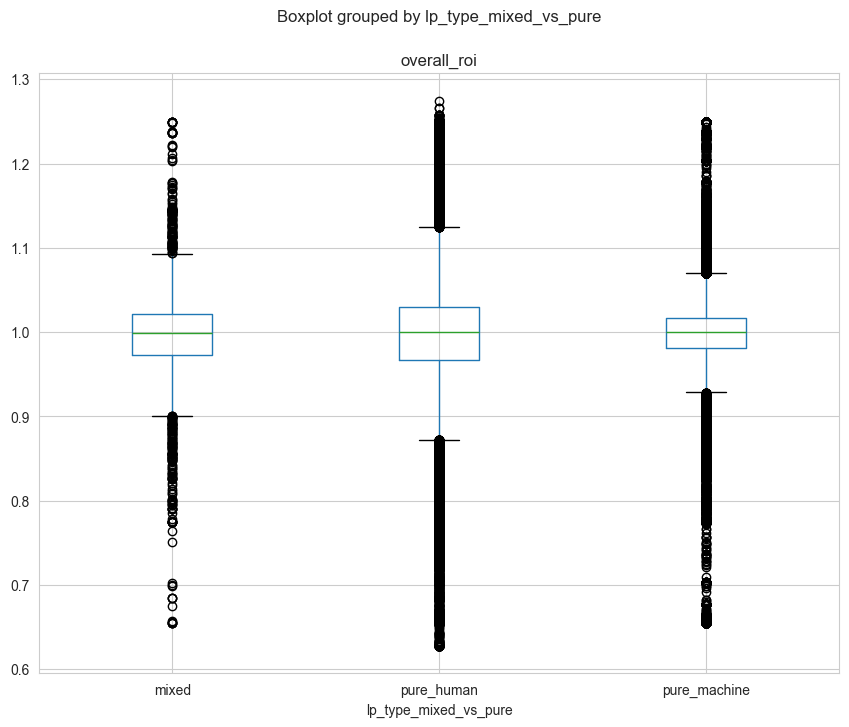

In [77]:
# pool_addr = '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36'
# price_info_given_pool = price_info[price_info["pool_address"] == pool_addr].copy()
# data_given_pool = data[data["pool_addr"]==pool_addr].copy()
# data_given_pool["cum_overall_roi"] = data_given_pool.groupby(['liquidity_provider'])["overall_roi"].cumprod()
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(10,8))
# plt.suptitle('')
# data_given_pool.boxplot(column=['overall_roi'], by='lp_type_mixed_vs_pure', ax=ax)

In [81]:
# take first week out to avoid same week effect?
data = data[~data["lp_last_type"].isna()]
for pool_addr in ['0x4e68ccd3e89f51c3074ca5072bbac773960dfa36','0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8']:
    price_info_given_pool = price_info[price_info["pool_address"] == pool_addr].copy()
    data_given_pool = data[data["pool_addr"]==pool_addr].copy()
    data_given_pool["cum_overall_roi"] = data_given_pool.groupby(['liquidity_provider'])["overall_roi"].cumprod()
    grouped_temp_data = data_given_pool.groupby(["lp_type_mixed_vs_pure_alternative" , "week"]).agg(
        cum_overall_mean=('cum_overall_roi', 'mean'),
        cum_overall_median=('cum_overall_roi', 'median'),
        cum_overall_q10=('cum_overall_roi', qtile_10),
        cum_overall_q25=('cum_overall_roi', qtile_25),
        cum_overall_q90=('cum_overall_roi', qtile_90),
        cum_overall_q75=('cum_overall_roi', qtile_75),
        weekly_overall_mean=('overall_roi', 'mean'),
        weekly_overall_median=('overall_roi', 'median'),
        weekly_overall_q10=('overall_roi', qtile_10),
        weekly_overall_q25=('overall_roi', qtile_25),
        weekly_overall_q90=('overall_roi', qtile_90),
        weekly_overall_q75=('overall_roi', qtile_75),
    ).reset_index()
    grouped_temp_data['date'] = pd.to_datetime(grouped_temp_data['week'])
    grouped_temp_data.set_index(['date'], inplace=True)
    col_names = ['cum_overall_mean', 'cum_overall_median', 'cum_overall_q10', 'cum_overall_q25', 'cum_overall_q75', 'cum_overall_q90',
                 'weekly_overall_mean', 'weekly_overall_median', 'weekly_overall_q10', 'weekly_overall_q25', 'weekly_overall_q75', 'weekly_overall_q90' ]
    for temp_col_name in col_names:
        import matplotlib.pyplot as plt
        # pure_human_cond = grouped_temp_data['lp_type_mixed_vs_pure'] == 'pure_human'
        # pure_machine_cond = grouped_temp_data['lp_type_mixed_vs_pure'] == 'pure_machine'
        # mixed_condition = grouped_temp_data['lp_type_mixed_vs_pure'] == 'mixed'
        # data_pure_human = grouped_temp_data[pure_human_cond].copy().reset_index()
        # data_pure_machine = grouped_temp_data[pure_machine_cond].copy().reset_index()
        # data_mixed = grouped_temp_data[mixed_condition].copy().reset_index()
        fig, ax1 = plt.subplots(figsize=(24, 8))
        # Plotting 'daily_fee_avg_winsorized' on the primary Y-axis
        # ax1.plot(data_pure_human['date'], data_pure_human[temp_col_name], label='Pure Human', color='blue', linestyle='--',)
        # ax1.plot(data_pure_machine['date'], data_pure_machine[temp_col_name], label='Pure Machine', color='green', linestyle='--')
        # ax1.plot(data_mixed['date'], data_mixed[temp_col_name], label='Machine and Human Mixed Strategy', color='red', linestyle='--')
        pure_cond = grouped_temp_data['lp_type_mixed_vs_pure_alternative'] == 'pure'
        mixed_condition = grouped_temp_data['lp_type_mixed_vs_pure_alternative'] == 'mixed'
        data_pure = grouped_temp_data[pure_cond].copy().reset_index()
        data_mixed = grouped_temp_data[mixed_condition].copy().reset_index()
        ax1.plot(data_pure['date'], data_pure[temp_col_name], label='LP Pure', color='blue', linestyle='--',)
        ax1.plot(data_mixed['date'], data_mixed[temp_col_name], label='LP Mixed', color='green', linestyle='--')
        # true_human_cond = grouped_temp_data['lp_type'] == 'rec_only'
        # false_human_cond = grouped_temp_data['lp_type'] == 'manual_only'
        # mixed_human_cond = grouped_temp_data['lp_type'] == 'rec_and_manual_mixed'
        # sc_cond = grouped_temp_data['lp_type'] == 'sc_only'

        # data_true = grouped_temp_data[true_human_cond].copy().reset_index()
        # data_false = grouped_temp_data[false_human_cond].copy().reset_index()
        # data_mixed = grouped_temp_data[mixed_human_cond].copy().reset_index()
        # data_sc = grouped_temp_data[sc_cond].copy().reset_index()
        # 'alive_positions', 'money_in_pool_total', 'money_in_pool_avg',
        #        'money_in_pool_median', 'daily_price', 'overall_earning_count',
        #        'overall_in_range', 'age_avg', 'age_median', 'in_range_perc',
        #        'overall_earning_perc'],
 
        #ax1.plot(data_non_sc['week'], data_non_sc[col_name], label='Human', color='blue', linestyle='--',)
        #ax1.plot(data_sc['week'], data_sc[col_name], label='SC', color='green', linestyle='--')
        # ax1.plot(data_true['date'], data_true[col_name], label='Rec ', color='green', linestyle='--')
        # ax1.plot(data_nonrec_and_rec['date'], data_nonrec_and_rec[temp_col_name+"_x"]/data_nonrec_and_rec[temp_col_name+"_y"], label='Non-rec vs Rec only', color='orange', linestyle='--')
        # ax1.plot(data_mixed_and_rec['date'], data_mixed_and_rec[temp_col_name+"_x"]/data_mixed_and_rec[temp_col_name+"_y"], label='Mixed vs Rec only', color='red', linestyle='--')
        ax1.axhline(y=1.0, color='blue', label='Baseline = 1.0')
        
        #ax1.plot(data_false['date'], data_false[col_name], label='Manual', color='orange', linestyle='--')
        #ax1.plot(data_sc['date'], data_sc[col_name], label='SC', color='green', linestyle='--')
        
        #ax1.plot(data_false['date'], data_false[col_name], label='Recommended = False', color='red', linestyle='--', alpha=0.7)
        ax1.set_xlabel('Date')
        ax1.set_ylabel(temp_col_name, color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.legend(loc='upper left')
        ax1.grid(True)
        
        plt.title(temp_col_name + ' in ' + pool_addr + ' Over Time')
        plt.savefig("/Users/allen/Downloads/graph_cum_roi_alltime/" + temp_col_name + '_' + pool_addr + ".png")
        plt.close()
    # Show the plot


In [80]:
data

,pool_addr,liquidity_provider,week,overall_roi,amt_roi,fee_roi,fee,amt,amt_last,amount_input,...,rec_type,lp_type_re_categorized_detailed,lp_type_mixed_vs_pure,lp_type_mixed_vs_pure_alternative,lp_last_type,lp_type_changed,lp_type_changed_cumsum,lp_type_changed_on_off,lp_type_changed_onset_time,lp_learning
1,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x000001138923c408ade761b2a2af2afe72858733,2022-11-27,1.024391,1.019874,0.004516,0.142243,32.122295,31.496325,0.0,...,no_rec,fully_manual,pure_human,pure,fully_manual,False,0,False,0,False
2,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x000001138923c408ade761b2a2af2afe72858733,2022-12-04,1.012125,1.009530,0.002595,0.083348,32.428425,32.122295,0.0,...,no_rec,fully_manual,pure_human,pure,fully_manual,False,0,False,0,False
3,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x000001138923c408ade761b2a2af2afe72858733,2022-12-11,0.960578,0.957229,0.003349,0.108598,31.041444,32.428425,0.0,...,no_rec,fully_manual,pure_human,pure,fully_manual,False,0,False,0,False
4,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x000001138923c408ade761b2a2af2afe72858733,2022-12-18,1.022629,1.020536,0.002093,0.064979,31.678906,31.041444,0.0,...,no_rec,fully_manual,pure_human,pure,fully_manual,False,0,False,0,False
5,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x000001138923c408ade761b2a2af2afe72858733,2022-12-25,0.987292,0.986118,0.001174,0.037188,31.239151,31.678906,0.0,...,no_rec,fully_manual,pure_human,pure,fully_manual,False,0,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899082,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xfffb40347816873ca038756cc87bc610144166b2,2022-11-27,1.025234,1.025234,0.000000,0.000000,1.862353,1.816515,0.0,...,no_rec,fully_manual,pure_human,pure,fully_manual,False,0,False,0,False
899083,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xfffb40347816873ca038756cc87bc610144166b2,2022-12-04,1.027115,1.027115,0.000000,0.000000,1.912851,1.862353,0.0,...,no_rec,fully_manual,pure_human,pure,fully_manual,False,0,False,0,False
899084,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xfffb40347816873ca038756cc87bc610144166b2,2022-12-11,0.935966,0.935966,0.000000,0.000000,1.790363,1.912851,0.0,...,no_rec,fully_manual,pure_human,pure,fully_manual,False,0,False,0,False
899085,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xfffb40347816873ca038756cc87bc610144166b2,2022-12-18,1.030263,1.030263,0.000000,0.000000,1.844544,1.790363,0.0,...,no_rec,fully_manual,pure_human,pure,fully_manual,False,0,False,0,False


In [8]:
data["status_never_changed"] = 'default_to_change'
status_change_list = [
    (data['rec_type_changed_times'] == 0) & (data['sc_type'] == 'no_sc'),
    (data['rec_type_changed_times'] == 0) & (data['sc_type'] == 'no_sc'),
]
status_choice_list = [
    'only_manual',
    'only_recommendation',
    'only_sc'
]
data['status_never_changed'] = np.select(sc_conditions_list, sc_choice_list, default='changed_status')

,pool_addr,liquidity_provider,week,overall_roi,amt_roi,fee_roi,fee,amt,amt_last,amount_input,...,rec_usage_avg,lp_type,sc_type,rec_type,sc_type_prev,rec_type_prev,sc_type_prev_changed,rec_type_prev_changed,sc_type_changed_times,rec_type_changed_times
0,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x000001138923c408ade761b2a2af2afe72858733,2022-11-20,1.016905,1.015120,0.001785,0.055383,31.496325,31.027203,31.027203,...,0.0,manual_only,no_sc,no_rec,NaN,NaN,False,False,0,0
1,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x000001138923c408ade761b2a2af2afe72858733,2022-11-27,1.024391,1.019874,0.004516,0.142243,32.122295,31.496325,0.000000,...,0.0,manual_only,no_sc,no_rec,no_sc,no_rec,False,False,0,0
2,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x000001138923c408ade761b2a2af2afe72858733,2022-12-04,1.012125,1.009530,0.002595,0.083348,32.428425,32.122295,0.000000,...,0.0,manual_only,no_sc,no_rec,no_sc,no_rec,False,False,0,0
3,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x000001138923c408ade761b2a2af2afe72858733,2022-12-11,0.960578,0.957229,0.003349,0.108598,31.041444,32.428425,0.000000,...,0.0,manual_only,no_sc,no_rec,no_sc,no_rec,False,False,0,0
4,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x000001138923c408ade761b2a2af2afe72858733,2022-12-18,1.022629,1.020536,0.002093,0.064979,31.678906,31.041444,0.000000,...,0.0,manual_only,no_sc,no_rec,no_sc,no_rec,False,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899082,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xfffb40347816873ca038756cc87bc610144166b2,2022-11-27,1.025234,1.025234,0.000000,0.000000,1.862353,1.816515,0.000000,...,0.0,manual_only,no_sc,no_rec,no_sc,no_rec,False,False,0,0
899083,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xfffb40347816873ca038756cc87bc610144166b2,2022-12-04,1.027115,1.027115,0.000000,0.000000,1.912851,1.862353,0.000000,...,0.0,manual_only,no_sc,no_rec,no_sc,no_rec,False,False,0,0
899084,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xfffb40347816873ca038756cc87bc610144166b2,2022-12-11,0.935966,0.935966,0.000000,0.000000,1.790363,1.912851,0.000000,...,0.0,manual_only,no_sc,no_rec,no_sc,no_rec,False,False,0,0
899085,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xfffb40347816873ca038756cc87bc610144166b2,2022-12-18,1.030263,1.030263,0.000000,0.000000,1.844544,1.790363,0.000000,...,0.0,manual_only,no_sc,no_rec,no_sc,no_rec,False,False,0,0


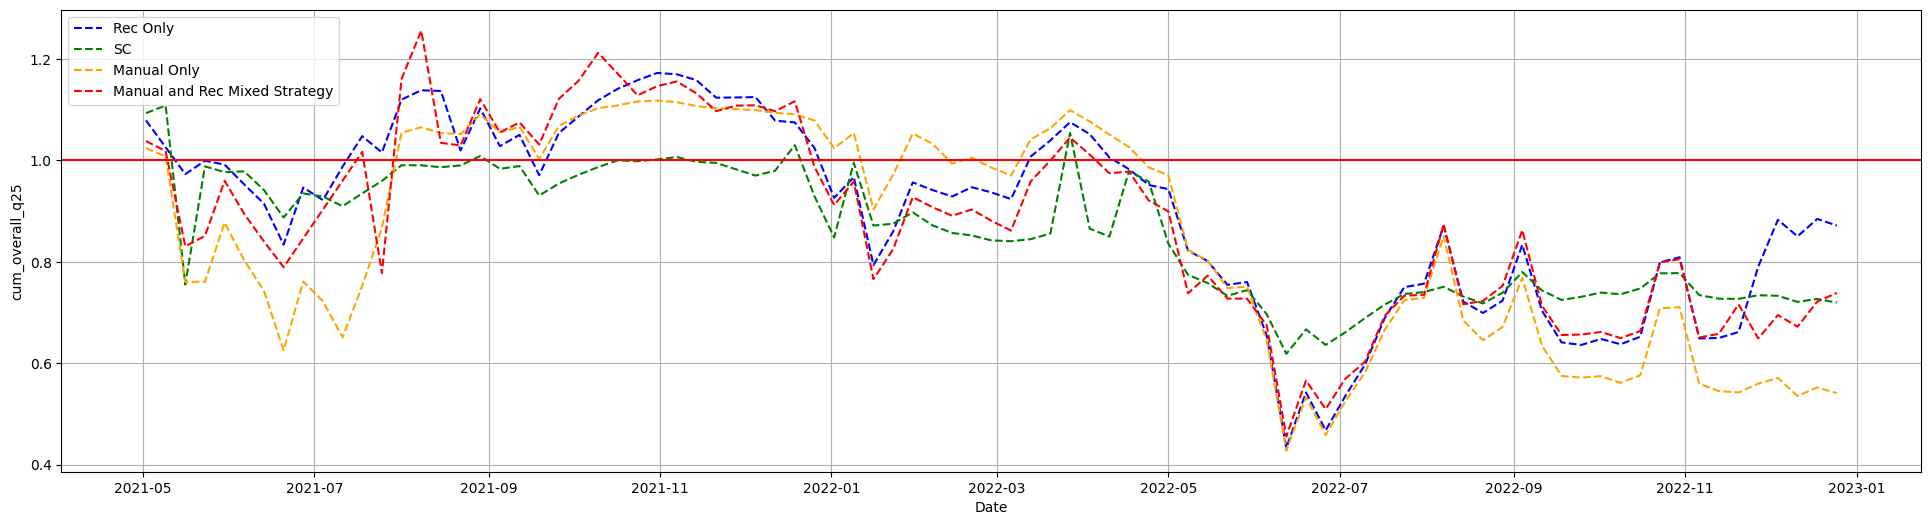

In [154]:

true_human_cond = grouped_temp_data['lp_type'] == 'rec_only'
false_human_cond = grouped_temp_data['lp_type'] == 'manual_only'
mixed_human_cond = grouped_temp_data['lp_type'] == 'rec_and_manual_mixed'
sc_cond = grouped_temp_data['lp_type'] == 'sc_only'
data_true = grouped_temp_data[true_human_cond].copy().reset_index()
data_false = grouped_temp_data[false_human_cond].copy().reset_index()
data_mixed = grouped_temp_data[mixed_human_cond].copy().reset_index()
data_sc = grouped_temp_data[sc_cond].copy().reset_index()
# 'alive_positions', 'money_in_pool_total', 'money_in_pool_avg',
#        'money_in_pool_median', 'daily_price', 'overall_earning_count',
#        'overall_in_range', 'age_avg', 'age_median', 'in_range_perc',
#        'overall_earning_perc',
# Creating a twin Y-axis for the 'daily_price' column
fig, ax1 = plt.subplots(figsize=(24, 6))
col_name = 'cum_overall_q25'
# Plotting 'daily_fee_avg_winsorized' on the primary Y-axis
ax1.plot(data_true['date'], data_true[col_name], label='Rec Only', color='blue', linestyle='--',)
ax1.plot(data_sc['date'], data_sc[col_name], label='SC', color='green', linestyle='--')
ax1.plot(data_false['date'], data_false[col_name], label='Manual Only', color='orange', linestyle='--')
ax1.plot(data_mixed['date'], data_mixed[col_name], label='Manual and Rec Mixed Strategy', color='red', linestyle='--')

#ax1.plot(data_sc['date'], data_sc[col_name], label='SC', color='green', linestyle='--')

#ax1.plot(data_false['date'], data_false[col_name], label='Recommended = False', color='red', linestyle='--', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(col_name, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.axhline(y=1.0, color='red', label='Baseline = 1.0')

<Axes: xlabel='week'>

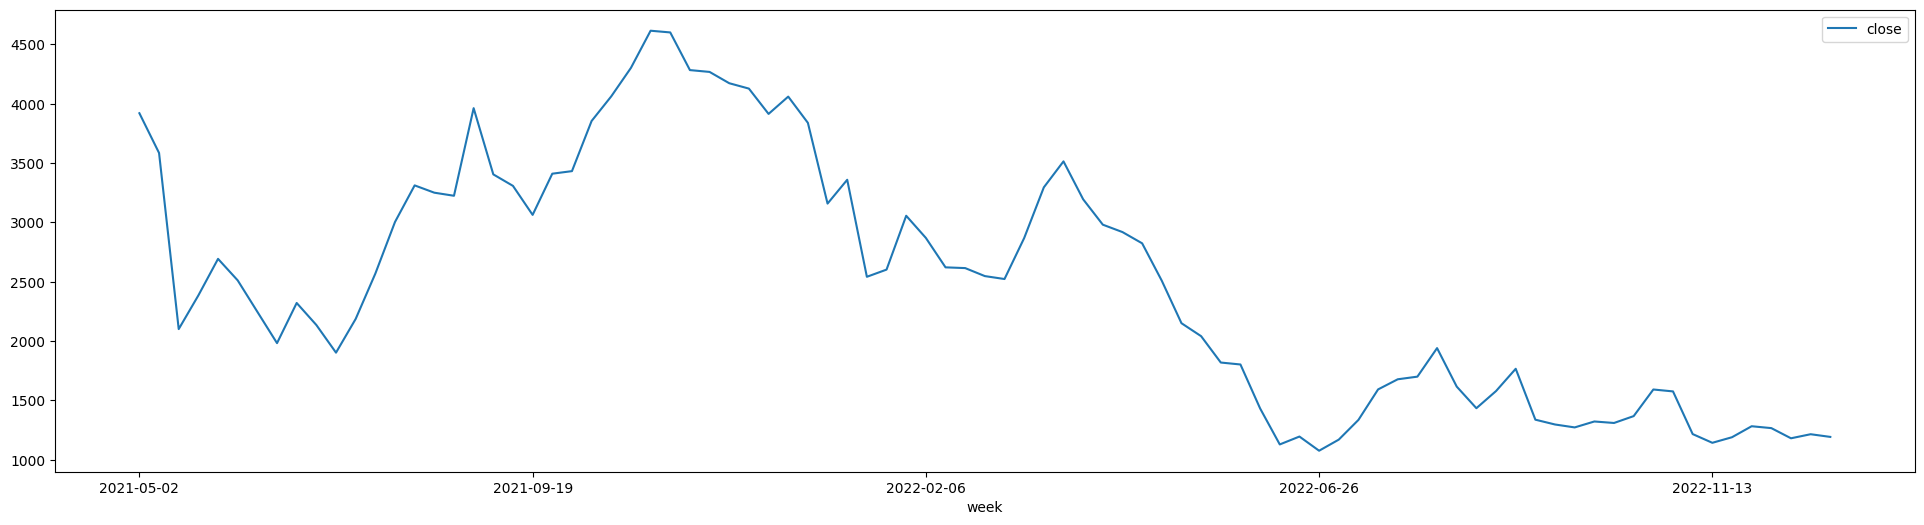

In [157]:
price_info_given_pool[["week", "close"]].plot(x='week', y='close', figsize=(24, 6))

In [57]:
data['sc_type_prev_changed'] = (~data['sc_type_prev'].isna()) & (data['sc_type_prev']!=data['sc_type'])
data['rec_type_prev_changed'] = (~data['rec_type_prev'].isna()) & (data['rec_type_prev']!=data['rec_type'])

In [98]:
sc_usage_changed_lp = data[data['sc_type_prev_changed']].groupby(["pool_addr"])["liquidity_provider"].unique().reset_index().explode("liquidity_provider")

In [99]:
rec_usage_changed_lp = data[data['rec_type_prev_changed']].groupby(["pool_addr"])["liquidity_provider"].unique().reset_index().explode("liquidity_provider")

In [100]:
data[data['sc_type_prev_changed']].groupby(["pool_addr"])["liquidity_provider"].nunique()

pool_addr
0x4e68ccd3e89f51c3074ca5072bbac773960dfa36     90
0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8    541
Name: liquidity_provider, dtype: int64

In [101]:
data[data['rec_type_prev_changed']].groupby(["pool_addr"])["liquidity_provider"].nunique()

pool_addr
0x4e68ccd3e89f51c3074ca5072bbac773960dfa36    170
0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8    557
Name: liquidity_provider, dtype: int64

In [102]:
data.merge(sc_usage_changed_lp, how='inner', on=['liquidity_provider', 'pool_addr'])

,pool_addr,liquidity_provider,week,overall_roi,amt_roi,fee_roi,fee,amt,amt_last,amount_input,...,rec_usage_avg,lp_type,sc_usage_avg_prev,rec_usage_avg_prev,sc_type,rec_type,sc_type_prev,rec_type_prev,sc_type_prev_changed,rec_type_prev_changed
0,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x04248fe487910f21fa3be187fc84b0873d1ff1af,2021-12-05,0.950801,0.947880,0.002922,10.852127,3520.956501,3714.559954,3714.559954,...,0.0,sc_only,NaN,NaN,full_sc,no_rec,NaN,NaN,False,False
1,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x04248fe487910f21fa3be187fc84b0873d1ff1af,2021-12-12,1.009655,0.999266,0.010390,2.586997,248.817816,249.000695,249.000695,...,0.0,sc_only,1.0,0.0,full_sc,no_rec,full_sc,no_rec,False,False
2,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x04248fe487910f21fa3be187fc84b0873d1ff1af,2021-12-26,0.968212,0.967552,0.000660,0.508916,745.552651,770.555753,770.555753,...,0.0,sc_only,1.0,0.0,full_sc,no_rec,full_sc,no_rec,False,False
3,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x04248fe487910f21fa3be187fc84b0873d1ff1af,2022-01-02,0.912574,0.906442,0.006133,3.722030,550.148703,606.932112,606.932112,...,0.0,sc_only,1.0,0.0,full_sc,no_rec,full_sc,no_rec,False,False
4,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,0x04248fe487910f21fa3be187fc84b0873d1ff1af,2022-01-23,1.036369,1.018045,0.018324,75.857604,4214.471897,4139.770919,4139.770919,...,0.0,sc_only,1.0,0.0,full_sc,no_rec,full_sc,no_rec,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22257,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xffe505d1753602e36cf91e97cf71ac2a328f2ae6,2022-11-27,1.022686,1.022443,0.000243,0.247868,1044.780334,1021.846557,0.000000,...,0.0,sc_only,1.0,0.0,full_sc,no_rec,full_sc,no_rec,False,False
22258,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xffe505d1753602e36cf91e97cf71ac2a328f2ae6,2022-12-04,1.024245,1.024122,0.000124,0.128930,1069.109754,1043.928275,0.000000,...,0.0,sc_only,1.0,0.0,full_sc,no_rec,full_sc,no_rec,False,False
22259,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xffe505d1753602e36cf91e97cf71ac2a328f2ae6,2022-12-11,0.943200,0.942800,0.000400,0.427846,1007.956347,1069.109754,0.000000,...,0.0,sc_only,1.0,0.0,full_sc,no_rec,full_sc,no_rec,False,False
22260,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,0xffe505d1753602e36cf91e97cf71ac2a328f2ae6,2022-12-18,1.025707,1.025640,0.000066,0.066783,1033.800747,1007.956347,0.000000,...,0.0,sc_only,1.0,0.0,full_sc,no_rec,full_sc,no_rec,False,False


In [103]:
final_grp_by_cond = ["pool_addr", "week", ]
test_res = data.merge(sc_usage_changed_lp, how='inner', on=['liquidity_provider', 'pool_addr']).groupby(final_grp_by_cond).agg(
            daily_overall_avg=('overall_roi', 'mean'),
            daily_amt_avg=('amt_roi', 'mean'),
            daily_fee_avg=('fee_roi', 'mean'),
            daily_overall_median=('overall_roi', 'median'),
            daily_amt_median=('amt_roi', 'median'),
            daily_fee_median=('fee_roi', 'median'),
        ).reset_index()

In [104]:
test_res_part_two = data[data["pool_addr"]==test_pool_addr].copy()

In [107]:
sc_changed_usage = sc_usage_changed_lp[sc_usage_changed_lp["pool_addr"]==test_pool_addr]["liquidity_provider"].unique().tolist()

In [108]:
consistent_type_lp_res = test_res_part_two[~test_res_part_two["liquidity_provider"].isin(sc_changed_usage)].groupby(['week', 'sc_type']).agg(
            daily_overall_avg=('overall_roi', 'mean'),
            daily_amt_avg=('amt_roi', 'mean'),
            daily_fee_avg=('fee_roi', 'mean'),
            daily_overall_median=('overall_roi', 'median'),
            daily_amt_median=('amt_roi', 'median'),
            daily_fee_median=('fee_roi', 'median'),
        ).reset_index()

In [110]:
consistent_type_lp_res["sc_type"].value_counts()

sc_type
full_sc    87
no_sc      87
mixed      84
Name: count, dtype: int64

In [111]:
changed_type_lp_res = test_res[test_res["pool_addr"]==test_pool_addr].copy()

In [112]:
import matplotlib.pyplot as plt

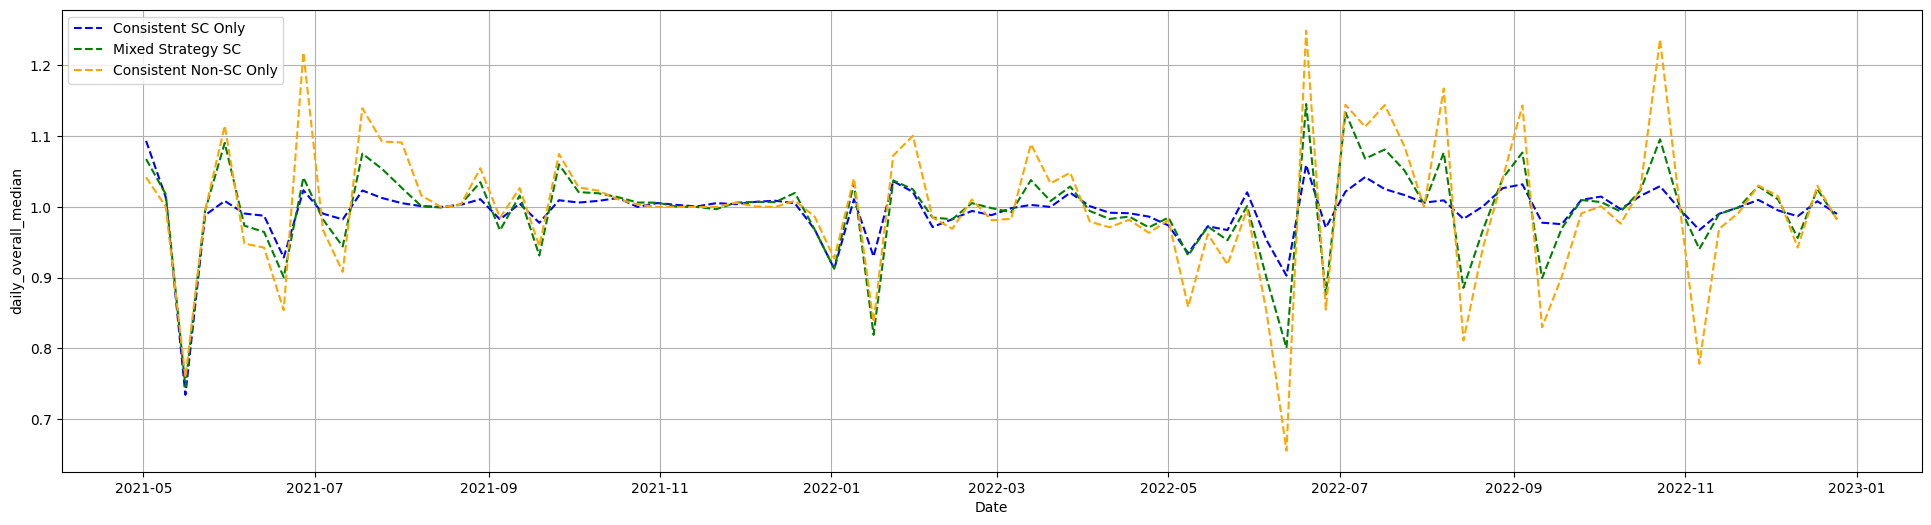

In [113]:
fig, ax1 = plt.subplots(figsize=(24, 6))
consistent_type_lp_res['week'] = pd.to_datetime(consistent_type_lp_res['week'])
consistent_type_lp_res.set_index(['week'])
changed_type_lp_res['week'] = pd.to_datetime(changed_type_lp_res['week'])
changed_type_lp_res.set_index(['week'])

consistent_sc = consistent_type_lp_res[consistent_type_lp_res["sc_type"] == 'full_sc']
consistent_nonsc = consistent_type_lp_res[consistent_type_lp_res["sc_type"] == 'no_sc']

col_name = 'daily_overall_median'
# Plotting 'daily_fee_avg_winsorized' on the primary Y-axis
ax1.plot(consistent_sc['week'], consistent_sc[col_name], label='Consistent SC Only', color='blue', linestyle='--',)
ax1.plot(changed_type_lp_res['week'], changed_type_lp_res[col_name], label='Mixed Strategy SC', color='green', linestyle='--')
ax1.plot(consistent_nonsc['week'], consistent_nonsc[col_name], label='Consistent Non-SC Only', color='orange', linestyle='--')
# ax1.plot(data_mixed['date'], data_mixed[col_name], label='Manual and Rec Mixed Strategy', color='red', linestyle='--')
ax1.set_xlabel('Date')
ax1.set_ylabel(col_name, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.show()

In [128]:
def qtile_75(x):
    return x.quantile(0.75)

In [129]:
qtile_75(pd.Series(np.arange(0.1, 1.1, 0.1)))

0.775

In [126]:
np.arange(0.1, 1.1, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])